<a href="https://colab.research.google.com/github/William1202-fox/titanic-ml-project/blob/main/titanic_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**0. kaggle API 載入 titanic 的資料**

In [2]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/ kaggle.json
!kaggle competitions download -c titanic
!unzip titanic.zip

chmod: cannot access 'kaggle.json': No such file or directory
  0% 0.00/34.1k [00:00<?, ?B/s]
100% 34.1k/34.1k [00:00<00:00, 105MB/s]
Archive:  titanic.zip
  inflating: gender_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


**1.1 先看檔案內容大概長怎樣(EDA)**

In [3]:
import pandas as pd
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train.head() #前5列長怎樣
train.shape  #(row, column)
train.info() #每欄型別與缺值
train.describe(include = 'all') #數值統計 & 類別統計

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Dooley, Mr. Patrick",male,NaN,NaN,NaN,347082,NaN,G6,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


**1.2 檢查缺值以百分比形式表示**
*   Cabin = 77.1% (丟棄)
*   Age = 19.9%
*   Embarked = 0.2%

In [4]:
def missing_ratio(df):
  return (df.isna().mean()*100).round(1).sort_values(ascending = False)

missing_ratio(train)

,0
Cabin,77.1
Age,19.9
Embarked,0.2
PassengerId,0.0
Name,0.0
Pclass,0.0
Survived,0.0
Sex,0.0
Parch,0.0
SibSp,0.0


**1.3 數值分布**
*   Fare分布偏右尾，需做log-transform

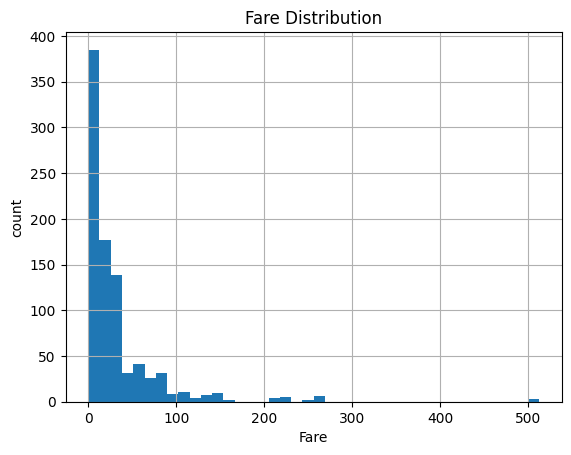

In [5]:
numeric_cols = ['Age', 'Fare' , 'SibSp', 'Parch'] #numeric_cols 自訂變數名
train[numeric_cols].describe().T #Tanspose 行列對調

#畫圖:
import matplotlib.pyplot as plt #Python 畫圖工具箱
train['Fare'].hist(bins = 40) #用直方圖觀察單欄位分布
plt.title('Fare Distribution')
plt.xlabel('Fare')
plt.ylabel('count')
plt.show()

**1.4 類別分布**
*   男:65%，女:35%
*   S港口:72%，C港口:19%，Q港口:9%
*   三等艙:55%，二等艙:24%，一等艙:21%

In [6]:
categorical_cols = ['Sex', 'Embarked', 'Pclass'] #categorical_cols 自訂變數名
for col in categorical_cols: #for迴圈跑list
  print((train[col].value_counts(normalize = True)*100).round(1)) #計算每個類別值出現次數，並將轉換成比例形式
  print('---')

Sex
male      64.8
female    35.2
Name: proportion, dtype: float64
---
Embarked
S    72.4
C    18.9
Q     8.7
Name: proportion, dtype: float64
---
Pclass
3    55.1
1    24.2
2    20.7
Name: proportion, dtype: float64
---


**1.5 生存率與特徵關係**
*   女性生存率74% > 男性19%
*   艙等生存率:一等艙63% > 二等艙47% > 三等艙24%
*   女性存活率高、頭等艙存活率高

In [7]:
#性別 vs 生存率
print(train.groupby('Sex')['Survived'].mean())

#艙等 vs 生存率
print(train.groupby('Pclass')['Survived'].mean())

#Embarked + Sex 交叉
pd.crosstab(train['Embarked'],
            train['Sex'],
            values = train['Survived'],
            aggfunc = 'mean')

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64
Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64


Sex,female,male
Embarked,,
C,0.876712,0.305263
Q,0.750000,0.073171
S,0.689655,0.174603


**2.1 特徵工程 -> 建立Baseline模型**
決定保留丟棄哪些欄位?

In [8]:
cols_drop = ['Cabin', 'Ticket', 'Name']
train = train.drop(columns = cols_drop)
test = test.drop(columns = cols_drop)

**2.2 建立特徵**
*   同艙親友人數
*   獨自一人

In [9]:
for df in [train, test]:
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)

**2.3 缺值填補與 One-Hot Encoding**

In [10]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

numeric_feats = ['Age', 'Fare', 'Pclass', 'SibSp', 'Parch', 'FamilySize'] #數值型
categorical_feats = ['Sex', 'Embarked', 'IsAlone'] #字串或類別型

numeric_transformer = SimpleImputer(strategy = 'median') #用中位數補缺值
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy = 'most_frequent')), #用最常見的補Embarked
    ('onehot', OneHotEncoder(handle_unknown = 'ignore'))
]) #測試集若出現訓練集沒見過的類別（罕見值），直接全部 0，不報錯

preprocess = ColumnTransformer(transformers = [
    ('num', numeric_transformer, numeric_feats),
    ('cat', categorical_transformer, categorical_feats)
])

**2.4 建立 Logistic Regression 基準模型**

In [11]:
from sklearn.linear_model import LogisticRegression #邏輯斯迴歸分類器
#資料分成「訓練集」與「驗證集」 #做 k-fold 交叉驗證，量測模型穩定度
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score #計算預測結果有多少百分比正確

X = train.drop(columns=['Survived'])
y = train['Survived']

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

#建立 sklearn Pipeline
baseline = Pipeline([
    ('pre', preprocess),
    ('clf', LogisticRegression(max_iter=1000))
])

#訓練與預測
baseline.fit(X_train, y_train)
preds = baseline.predict(X_valid)

#算出正確率
print("Validation accuracy:", accuracy_score(y_valid, preds))


Validation accuracy: 0.8044692737430168


**2.5 用 5-Fold Cross-Validation 再確認**

In [12]:
cv_scores = cross_val_score(baseline, X, y, cv=5, scoring='accuracy')
print("CV mean:", cv_scores.mean(), "std:", cv_scores.std())

CV mean: 0.7901450003138535 std: 0.022970976403544067


**2.6 Random Forest模型**

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score

rf = RandomForestClassifier(
    n_estimators=400,     # 樹數量
    max_depth=None,       # 先不限制深度
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)

model_rf = Pipeline([
    ('pre', preprocess),
    ('clf', rf)
])

# 交叉驗證看看
cv = cross_val_score(model_rf, X, y, cv=5, scoring='accuracy', n_jobs=-1)
print("RF CV mean:", cv.mean(), "std:", cv.std())

RF CV mean: 0.8069801016885318 std: 0.02771748219995446


In [14]:
param_dist = {
    'clf__n_estimators': [300, 400, 600],
    'clf__max_depth': [None, 5, 8, 12],
    'clf__min_samples_split': [2, 4, 6],
    'clf__min_samples_leaf': [1, 2, 3]
}

search = RandomizedSearchCV(
    model_rf, param_distributions=param_dist,
    n_iter=20, cv=5, scoring='accuracy', n_jobs=-1, random_state=42
)
search.fit(X, y)
print("Best CV:", search.best_score_)
best_model = search.best_estimator_


Best CV: 0.8282907538760907


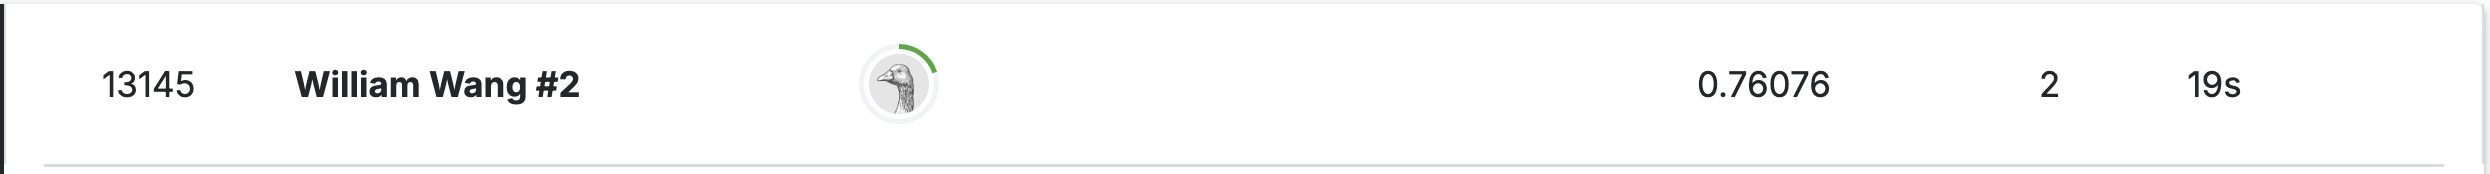

In [15]:
best_model.fit(X, y)

test_feats = test.copy()

final_preds = best_model.predict(test_feats)

submission = pd.DataFrame({
    'PassengerId': test['PassengerId'],
    'Survived': final_preds
})

submission.to_csv('submission.csv', index=False)
